<a href="https://colab.research.google.com/github/NavanjanaLAV/SE4050-deeplearning-2025/blob/main/DL_CNN_Mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical


To download the dataset from Kaggle, you need to install the `kaggle` library and configure your Kaggle API credentials.

1.  **Install the library:**

In [4]:
%pip install kaggle

2.  **Configure your Kaggle API credentials:**

    Go to your Kaggle account settings, scroll down to the "API" section, and click "Create New API Token". This will download a `kaggle.json` file. You need to upload this file to your Colab environment. You can do this by clicking on the folder icon in the left sidebar, then clicking the "Upload to session storage" icon, and selecting the `kaggle.json` file.

    After uploading, you need to move the file to the correct directory and set the necessary permissions:

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


3.  **Download the dataset:**

    Now you can use the Kaggle API to download the dataset. The dataset name is usually in the URL after `/datasets/`. In this case, it's `clmentbisaillon/fake-and-real-news-dataset`.

In [6]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


4.  **Unzip the dataset and load the data:**

    The downloaded file is usually a zip file. You need to unzip it and then load the data into a pandas DataFrame.

In [9]:
import zipfile
import os

# Unzip the downloaded file
with zipfile.ZipFile('fake-and-real-news-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Load the data
real_news_df = pd.read_csv('True.csv')
fake_news_df = pd.read_csv('Fake.csv')

# Add a 'label' column to each DataFrame
real_news_df['label'] = 'real'
fake_news_df['label'] = 'fake'

# Combine the datasets
data = pd.concat([real_news_df, fake_news_df], ignore_index=True)

# Display basic info
print(data.head())
print(data['label'].value_counts())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date label  
0  December 31, 2017   real  
1  December 29, 2017   real  
2  December 31, 2017   real  
3  December 30, 2017   real  
4  December 29, 2017   real  
label
fake    23481
real    21417
Name: count, dtype: int64


3. Encode Labels

In [10]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])  # fake=0, real=1


4. Split Data

In [11]:
X = data['title'].astype(str)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


5. Tokenize and Pad Sequences

In [12]:
# Tokenization parameters
max_words = 10000  # use top 10,000 frequent words
max_len = 50       # max length of headline

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


6. Build CNN **Model**

In [13]:
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

7. Train the Model

In [14]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.8674 - loss: 0.2923 - val_accuracy: 0.9658 - val_loss: 0.0932
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9859 - loss: 0.0413 - val_accuracy: 0.9688 - val_loss: 0.0948
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9951 - loss: 0.0173 - val_accuracy: 0.9656 - val_loss: 0.1288
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9962 - loss: 0.0097 - val_accuracy: 0.9669 - val_loss: 0.1442
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.9663 - val_loss: 0.1638
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9669 - val_loss: 0.1926
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9985 - loss: 0.0045 - val_accuracy: 0.9651 - val_loss: 0.1910
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9991 - loss: 0.0029 - 

8. Evaluate the Model

In [15]:
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")


✅ Test Accuracy: 96.56%


9. Plot Training Performance

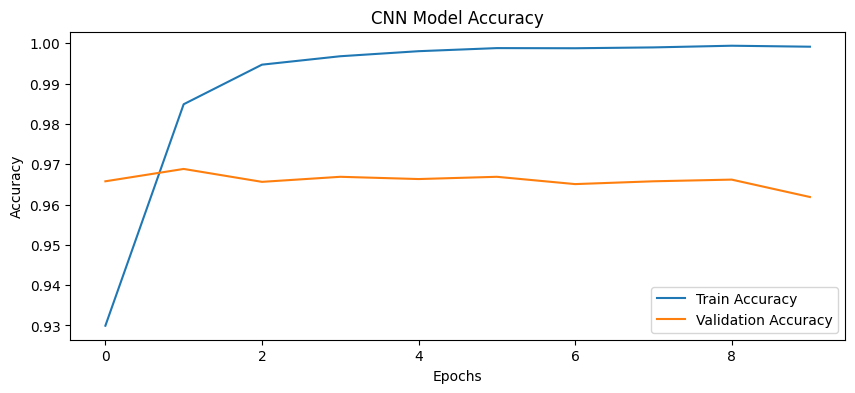

In [16]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


10. Make Predictions

In [17]:
def predict_headline(headline):
    seq = tokenizer.texts_to_sequences([headline])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(pad)[0][0]
    return "Real" if pred > 0.5 else "Fake"

# Example test
print(predict_headline("Breaking: Scientists discover a cure for cancer!"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Fake
